In [45]:
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *
     

import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

from torcheval.metrics import MulticlassAccuracy

import logging
logging.disable(logging.WARNING)

In [46]:
def set_seed(seed, deterministic=True):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [47]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

In [48]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [49]:
ds = dsd.with_transform(transformi)

In [50]:
dls = DataLoaders.from_dd(ds, bs, num_workers=4)
dt = dls.train
dv = dls.valid

In [51]:
def conv(n_in, n_out, ks=3, act=True):
    res = nn.Conv2d(n_in, n_out, ks, stride=2, padding=ks//2)
    if act: return nn.Sequential(res, nn.ReLU())
    return res

In [52]:
def get_cnn():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [53]:
metrics = MetricsCB(MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [54]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

In [55]:
set_seed(1)

MulticlassAccuracy,loss,epoch,train
0.161,2.298,0,train
0.183,2.163,0,eval


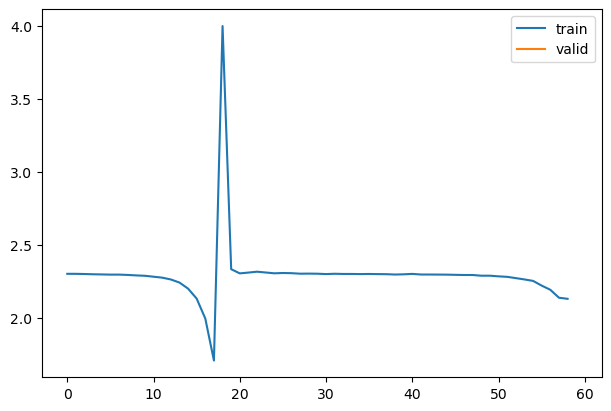

In [56]:
learn = fit(nn.Sequential(*get_cnn()))

In [57]:
def append_act(hook, module,n_inps, n_outs):
    if not hasattr(hook, 'stats'): hook.stats=[[],[]]
    hook.stats[0].append(to_cpu(n_outs).mean())
    hook.stats[1].append(to_cpu(n_outs).std())

In [58]:
class Hook():
    def __init__(self, m,f): self.hook = m.register_forward_hook(partial(f,self))
    def __del__(self): self.remove()
    def remove(self): self.hook.remove()

MulticlassAccuracy,loss,epoch,train
0.161,2.298,0,train
0.183,2.163,0,eval


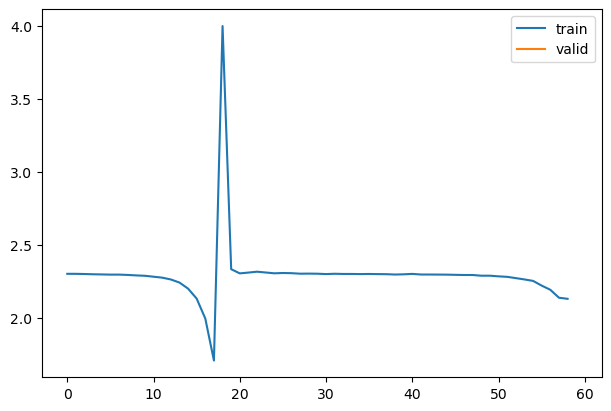

In [59]:
set_seed(1)
model = nn.Sequential(*get_cnn())
hooks = [Hook(m,append_act) for m in model.children()]
fit(model)

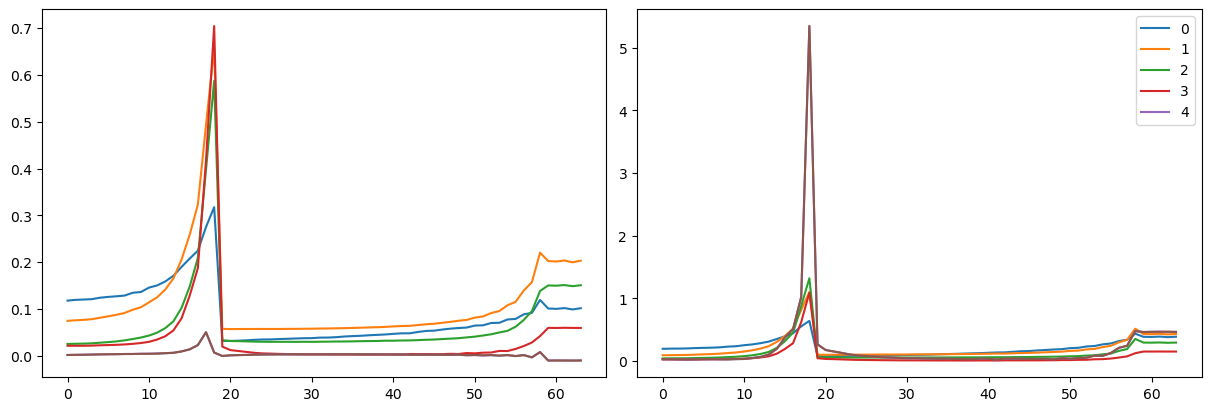

In [60]:
fig, axes = plt.subplots(1,2, figsize=(12,4)) 
for h in hooks: 
    axes[0].plot(h.stats[0])
    axes[1].plot(h.stats[1])
    h.remove()
plt.legend(range(5))

In [61]:
class Hooks(list):
    def __init__(self, model, func): super().__init__([Hook(m,func) for m in model])
    def __enter__(self, *args): return self
    def __exit__(self,*args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self): 
        for h in self: h.remove()

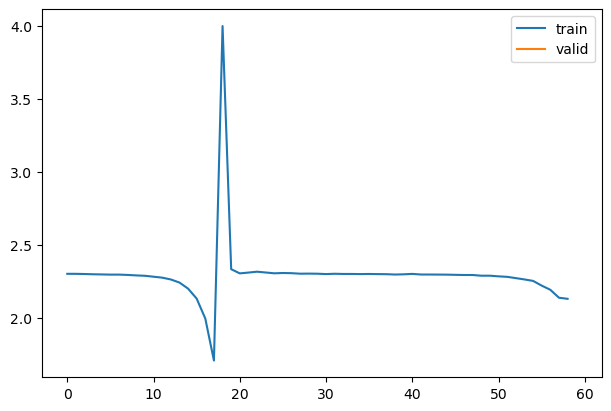

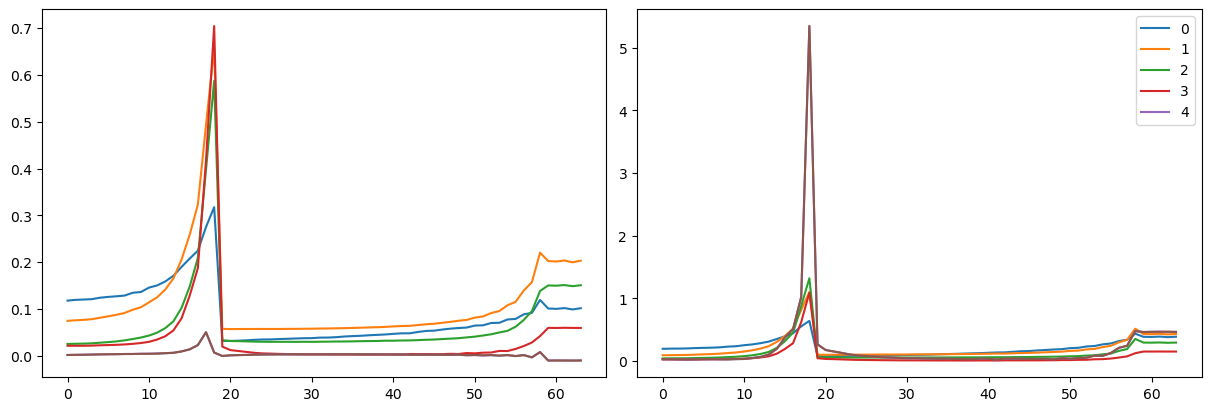

In [62]:
set_seed(1)
model = nn.Sequential(*get_cnn())
with Hooks(model, append_act) as hooks:
    fit(model)
    fig, axes = plt.subplots(1,2, figsize=(12,4)) 
for h in hooks: 
    for i in 0,1: axes[i].plot(h.stats[i])
plt.legend(range(5))

In [63]:
hooks

In [64]:
class HooksCB(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None): 
        fc.store_attr()
        #super().__init__()

    def before_fit(self,learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if  (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)
    
    def after_fit(self,learn):
        for h in self.hooks: h.remove()

    def __iter__(self): return iter(self.hooks)
    def __len__(self) : return len(self.hooks)

In [74]:
set_seed(1)
model = nn.Sequential(*get_cnn())
hc = HooksCB(append_act, mod_filter=fc.risinstance(nn.Conv2d))

MulticlassAccuracy,loss,epoch,train
0.161,2.298,0,train
0.183,2.163,0,eval


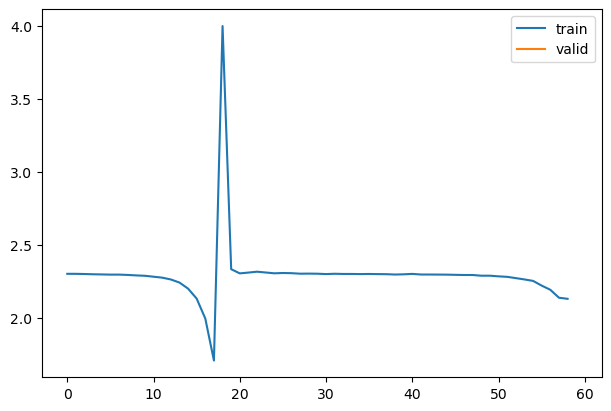

In [75]:
learn = fit(model, xtra_cbs=[hc])

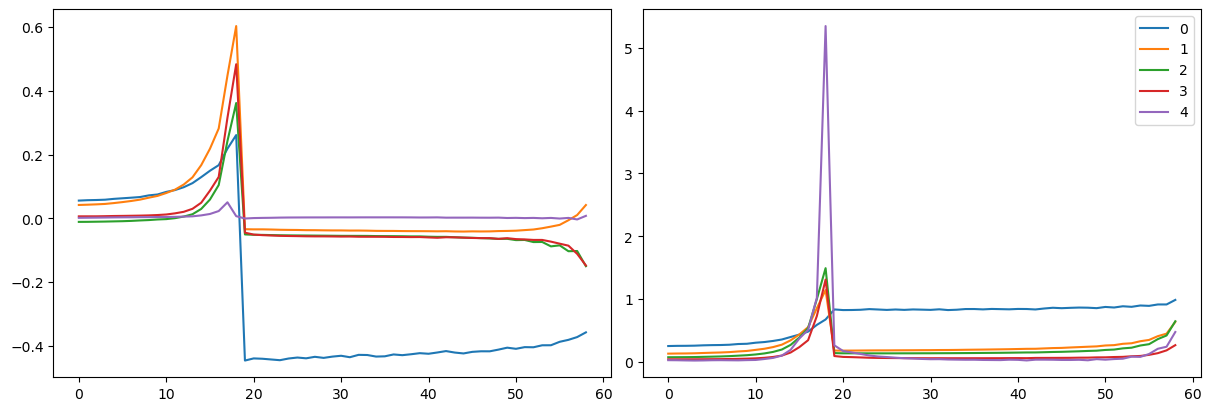

In [76]:
fig, axes = plt.subplots(1,2, figsize=(12,4)) 
for h in hc: 
    for i in 0,1: axes[i].plot(h.stats[i])
plt.legend(range(5))

In [23]:
def append_act(hook, module,n_inps, n_outs):
    if not hasattr(hook, 'stats'): hook.stats=[[],[],[]]
    hook.stats[0].append(to_cpu(n_outs).mean())
    hook.stats[1].append(to_cpu(n_outs).std())
    hook.stats[2].append(to_cpu(n_outs).abs().histc(40,0,10))


In [24]:
def hist(hc): return torch.stack(hc.stats[2]).t().float().log1p()

In [25]:
def get_min(hc):
    hcc = torch.stack(hc.stats[2]).t().float()
    return hcc[0]/hcc.sum(0)

In [26]:
class ActivationStats(HooksCB):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_act,mod_filter)

    def get_hist(self, figsize=(11,5)):
        fig, axes = get_grid(len(self),figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(hist(h), ax, origin='lower')

    def dead_cell(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=(11,5))
        for ax,h in zip(axes.flat, self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def act_lay(self):
        fig, axes = plt.subplots(1,2, figsize=(12,4)) 
        for h in hc: 
            for i in 0,1: axes[i].plot(h.stats[i])
            plt.legend(fc.L.range(self))

In [27]:
set_seed(1)
model = nn.Sequential(*get_cnn())
astat = ActivationStats(fc.risinstance(nn.Conv2d))

MulticlassAccuracy,loss,epoch,train
0.161,2.298,0,train
0.183,2.163,0,eval


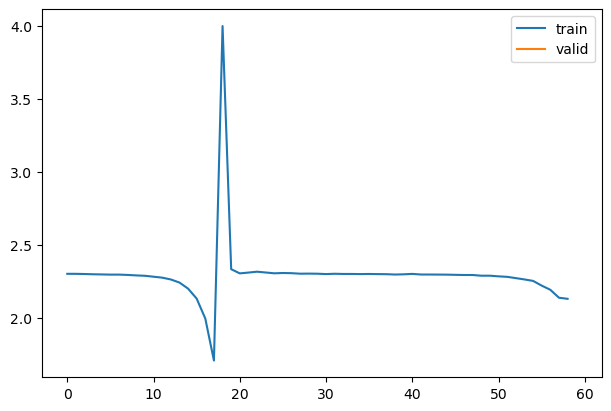

In [28]:
learn = fit(model, xtra_cbs=[astat])

TypeError: 'ActivationStats' object is not iterable

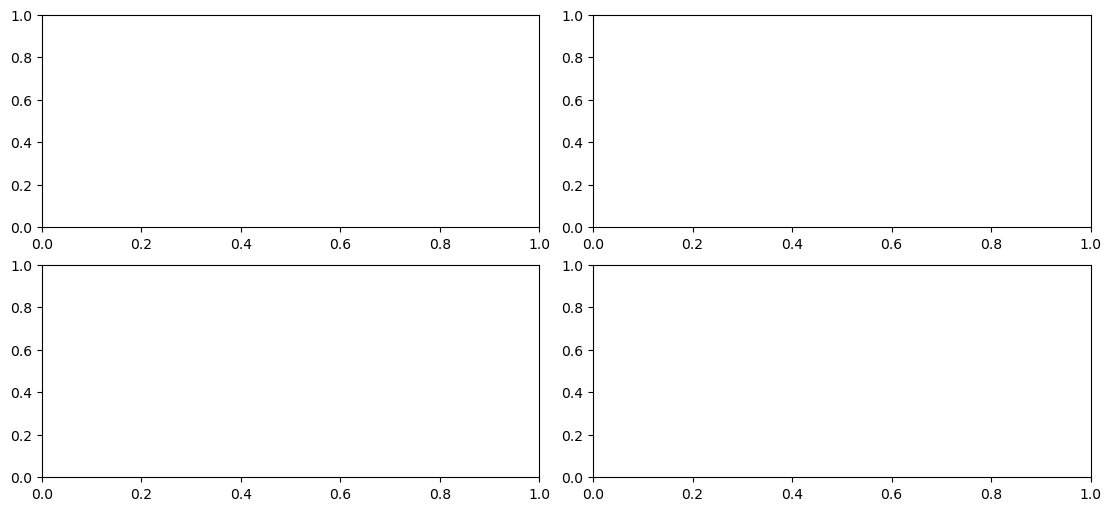

In [29]:
astat.get_hist()

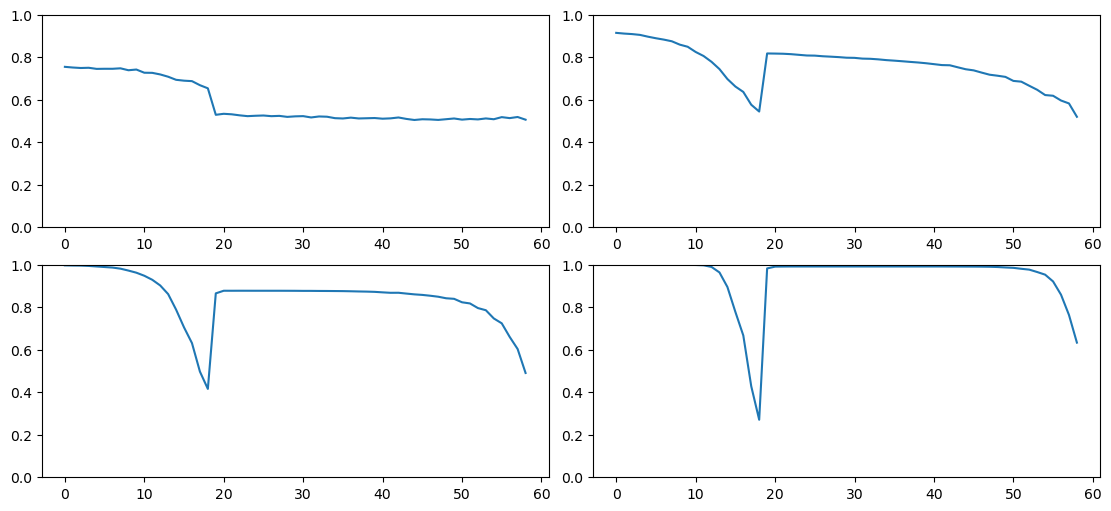

In [142]:
astat.dead_cell()

In [136]:
for h in astat:
    print(torch.stack(h.stats[2]).t().float().log1p().shape)

torch.Size([40, 59])
torch.Size([40, 59])
torch.Size([40, 59])
torch.Size([40, 59])
torch.Size([40, 59])


In [137]:
for h in astat:
    print(torch.stack(h.stats[2]).float().log1p().shape)

torch.Size([59, 40])
torch.Size([59, 40])
torch.Size([59, 40])
torch.Size([59, 40])
torch.Size([59, 40])
